## Setting up a 3D Riemann Problem for the Euler equations

### Introduction

This case considers a 3D RP recently proposed in Hoppe et al. (2024). As stated by the authors, in this case, all sides of the cube resemble the same 2D case corresponding to ‘Configuration 4’ of Lax et al. (1998) and develop 12 shock waves. The interaction of the waves in the center deforms the shock fronts. In the plane $(1,1,1)$ we observe the sub-sonic region to be bounded by joining shock fronts and the reflected shock waves. The interaction of the initial shock waves produces an arrow-like shape of the sub-sonic region. In the super-sonic region, a second set of reflected shock waves occurs.   In the  plane $(-1,-1,1)$ the sub-sonic region collapses to a circular shape. The second set of reflected shock waves also contracts and touches the sub-sonic region.

References:

- Nils Hoppe, Nico Fleischmann, Benedikt Biller, Stefan Adami, Nikolaus A. Adams, A systematic analysis of three-dimensional Riemann problems for verification of compressible-flow solvers, Computers & Fluids, Volume 278, 2024, 106298. [https://doi.org/10.1016/j.compfluid.2024.106298](https://doi.org/10.1016/j.compfluid.2024.106298)
- Lax, P. D., & Liu, X. D. (1998). Solution of two-dimensional Riemann problems of gas dynamics by positive schemes. SIAM Journal on Scientific Computing, 19(2), 319-340.


### Importing required libraries

Some of these are well known libraries such as *numpy* and *matplotlib* (they can be installed using pip). We also need to import the library *utils* containing predefined functionalities for this software. Additionally, we use the *pyvista* library to do 3D rendering.

In [1]:
import os
import math                    
import numpy as np             
import matplotlib.pyplot as plt 
import re
from glob import glob
from utils import modify_header_file,write_config,write_initial,write_equilibrium,backup_file,restore_file,compile_program,compile_program_jupyter,run_program,initialize_variables,read_data_euler
import imageio
import pyvista as pv

### Setting up the paths

First, the name of the folder for this test case must be specified:

In [2]:
#This test case will run in the folder "caseRP3D/". 
#Don't forget the bar (/). 
folder_case="caseRP3D/" 

Then, all the paths are automatically assigned, directories created and previous files removed:

In [3]:
#Do not modify the folders and paths below
script_dir = os.getcwd()
folder_out="out/"
folder_lib="lib"
fname_config="configure.input"
fname_eq="equilibrium.out"
fname_ini="initial.out"
folder_out = os.path.join(script_dir, "../"+folder_case+"/"+folder_out)
folder_case = os.path.join(script_dir, "../"+folder_case)
folder_lib = os.path.join(script_dir, "../"+folder_lib)
folder_exe = os.path.join(script_dir, "../")
os.makedirs(folder_case, exist_ok=True)
os.makedirs(folder_out, exist_ok=True)
for f in glob(folder_out + "/*.out") + glob(folder_out + "/*.vtk") + glob(folder_out + "/*.png"):
    os.remove(f) 

### Setting up the compilation variables (*definitions.h*)

Here, we can modify those variables that need to be set before compilation and are found in the file *definitions.h*. Don't worry if you mess up things here, a backup of the original file is created before modification and will be restored at the end of this script, after compilation and execution.

In [4]:
#Do not change the line below, it creates a backup of the definitions.h file
backup_file(folder_lib+'/definitions.h')
#Configure the header file for compilation. Add as many lines as desired for the macros you want to modify.
modify_header_file(folder_lib+'/definitions.h', 'NTHREADS', 48)         #number of threads
modify_header_file(folder_lib+'/definitions.h', 'TYPE_REC', 0)         #WENO reconstruction
modify_header_file(folder_lib+'/definitions.h', 'EQUATION_SYSTEM', 2)  #System of equations solved: Euler
modify_header_file(folder_lib+'/definitions.h', 'ST', 0)               #Source term type: no source
modify_header_file(folder_lib+'/definitions.h', 'SOLVER', 1)           #Riemann solver used: HLLC
modify_header_file(folder_lib+'/definitions.h', 'READ_INITIAL', 1)     #Read or not initial data, this should ALWAYS be 1
modify_header_file(folder_lib+'/definitions.h', 'WRITE_LIST', 0)  #Do not print *.out files, we will just open VTK files 

Backup created at /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h.bak
NTHREADS changed to 48 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h
TYPE_REC changed to 0 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h
EQUATION_SYSTEM changed to 2 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h
ST changed to 0 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h
SOLVER changed to 1 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h
READ_INITIAL changed to 1 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h
WRITE_LIST changed to 0 in /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h


### Configure the global simulation parameters

We can set the global simulation parameters as desired:

In [5]:
#Simulation setup
FinalTime = 0.15
DumpTime = 0.025
CFL = 0.2
Order = 7

#Mesh setup
xcells = 100
ycells = 100
zcells = 100
SizeX = 1.0
SizeY = 1.0
SizeZ = 1.0

#Boundary conditions
Face_1 = 3 #-y
Face_2 = 3 #+x
Face_3 = 3 #+y
Face_4 = 3 #-x
Face_5 = 3 #-z
Face_6 = 3 #+z

#Linear transport, only if applicable
u_x = 1.0
u_y = 1.0
u_z = 1.0

### Define the initial condition

To define the initial condition we first need to create the arrays and initialize some variables:

In [6]:
xc, yc, zc, u, v, w, rho, p, phi, *_ = initialize_variables(xcells, ycells, zcells, SizeX, SizeY, SizeZ)

Then we can set the initial condition using those variables. To do this, we loop over the three cartesian indexes $(l,m,n)$ and assign the variables, e.g. $\rho(x_l,y_m,z_n)=...$ is set as ```rho[l,m,n]=...```. Cell centers are given by: ```xc[l,m,n]```, ```yc[l,m,n]``` and ```zc[l,m,n]```.

In [7]:
#Initial condition and equilibrium state  from https://doi.org/10.1016/j.compfluid.2024.106298   , face number indicated according to reference       
for l in range(0,xcells): 
    for m in range(0,ycells):
        for n in range(0,zcells):
            if (zc[l,m,n]<0.5):
                if (xc[l,m,n]<0.5 and yc[l,m,n]<0.5): #3
                    rho[l,m,n]=1.1
                    p  [l,m,n]=1.1
                    u  [l,m,n]=0.893871
                    v  [l,m,n]=0.893871
                    w  [l,m,n]=0.893871
                    phi[l,m,n]=1.0
                elif (xc[l,m,n]<0.5 and yc[l,m,n]>0.5): #2
                    rho[l,m,n]=0.506475
                    p  [l,m,n]=0.35
                    u  [l,m,n]=0.893871
                    v  [l,m,n]=0.0
                    w  [l,m,n]=0.893871
                    phi[l,m,n]=0.0 
                elif (xc[l,m,n]>0.5 and yc[l,m,n]>0.5): #1
                    rho[l,m,n]=1.1
                    p  [l,m,n]=1.1
                    u  [l,m,n]=0.0
                    v  [l,m,n]=0.0
                    w  [l,m,n]=0.893871
                    phi[l,m,n]=0.0 
                else: #4
                    rho[l,m,n]=0.506475
                    p  [l,m,n]=0.35
                    u  [l,m,n]=0.0
                    v  [l,m,n]=0.893871
                    w  [l,m,n]=0.893871
                    phi[l,m,n]=0.0 
            else:
                if (xc[l,m,n]<0.5 and yc[l,m,n]<0.5): #7
                    rho[l,m,n]=0.506475
                    p  [l,m,n]=0.35
                    u  [l,m,n]=0.893871
                    v  [l,m,n]=0.893871
                    w  [l,m,n]=0.0
                    phi[l,m,n]=1.0
                elif (xc[l,m,n]<0.5 and yc[l,m,n]>0.5): #6
                    rho[l,m,n]=1.1
                    p  [l,m,n]=1.1
                    u  [l,m,n]=0.893871
                    v  [l,m,n]=0.0
                    w  [l,m,n]=0.0
                    phi[l,m,n]=1.0
                elif (xc[l,m,n]>0.5 and yc[l,m,n]>0.5): #5
                    rho[l,m,n]=0.506475
                    p  [l,m,n]=0.35
                    u  [l,m,n]=0.0
                    v  [l,m,n]=0.0
                    w  [l,m,n]=0.0
                    phi[l,m,n]=1.0
                else: #8
                    rho[l,m,n]=1.1
                    p  [l,m,n]=1.1
                    u  [l,m,n]=0.0
                    v  [l,m,n]=0.893871
                    w  [l,m,n]=0.0
                    phi[l,m,n]=1.0

Now, the configuration and initial condition (and equilibrium) files are written: 

In [8]:
write_config(folder_case, fname_config, FinalTime, DumpTime, CFL, Order, xcells, ycells, zcells, SizeX, SizeY, SizeZ, Face_1, Face_2, Face_3, Face_4, Face_5, Face_6, u_x, u_y, u_z)      
write_initial(folder_case, fname_ini, xcells, ycells, zcells, xc, yc, zc, u, v, w, rho, p, phi)

### Compilation and execution

The program is compiled and executed:

In [9]:
compile_program_jupyter()
restore_file(folder_lib+'/definitions.h')
print("Program is running...")
run_program(folder_exe+"./caelum "+folder_case)

Running clean command...
rm -f lib/preproc.o lib/ibmutils.o lib/mathutils.o lib/closures.o lib/reconst.o lib/numcore.o lib/solvers.o lib/postproc.o main.o caelum

Running compile command...
gcc -Wall -fopenmp -O3 -c -o lib/preproc.o lib/preproc.c
gcc -Wall -fopenmp -O3 -c -o lib/ibmutils.o lib/ibmutils.c
gcc -Wall -fopenmp -O3 -c -o lib/mathutils.o lib/mathutils.c
gcc -Wall -fopenmp -O3 -c -o lib/closures.o lib/closures.c
gcc -Wall -fopenmp -O3 -c -o lib/reconst.o lib/reconst.c
gcc -Wall -fopenmp -O3 -c -o lib/numcore.o lib/numcore.c
gcc -Wall -fopenmp -O3 -c -o lib/solvers.o lib/solvers.c
gcc -Wall -fopenmp -O3 -c -o lib/postproc.o lib/postproc.c
gcc -Wall -fopenmp -O3 -c -o main.o main.c
gcc -Wall -fopenmp -O3 -o caelum lib/preproc.o lib/ibmutils.o lib/mathutils.o lib/closures.o lib/reconst.o lib/numcore.o lib/solvers.o lib/postproc.o main.o -lm
Compilation successful
File restored from /home/pc/Escritorio/pr/EHOW3D_public/python/../lib/definitions.h.bak and backup removed
Program is

### Reading data and plotting

This can be customized for each particular case.  In this case, we use *pyvista* to read the VTK files and carry out some 3D plots. The plots are saved as PNG images and a GIF animation is also created.

['/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state000.vtk', '/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state001.vtk', '/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state002.vtk', '/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state003.vtk', '/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state004.vtk', '/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state005.vtk', '/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/state006.vtk']
Printing figures in folder/home/pc/Escritorio/pr/EHOW3D_public/python/../caseRP3D//out/


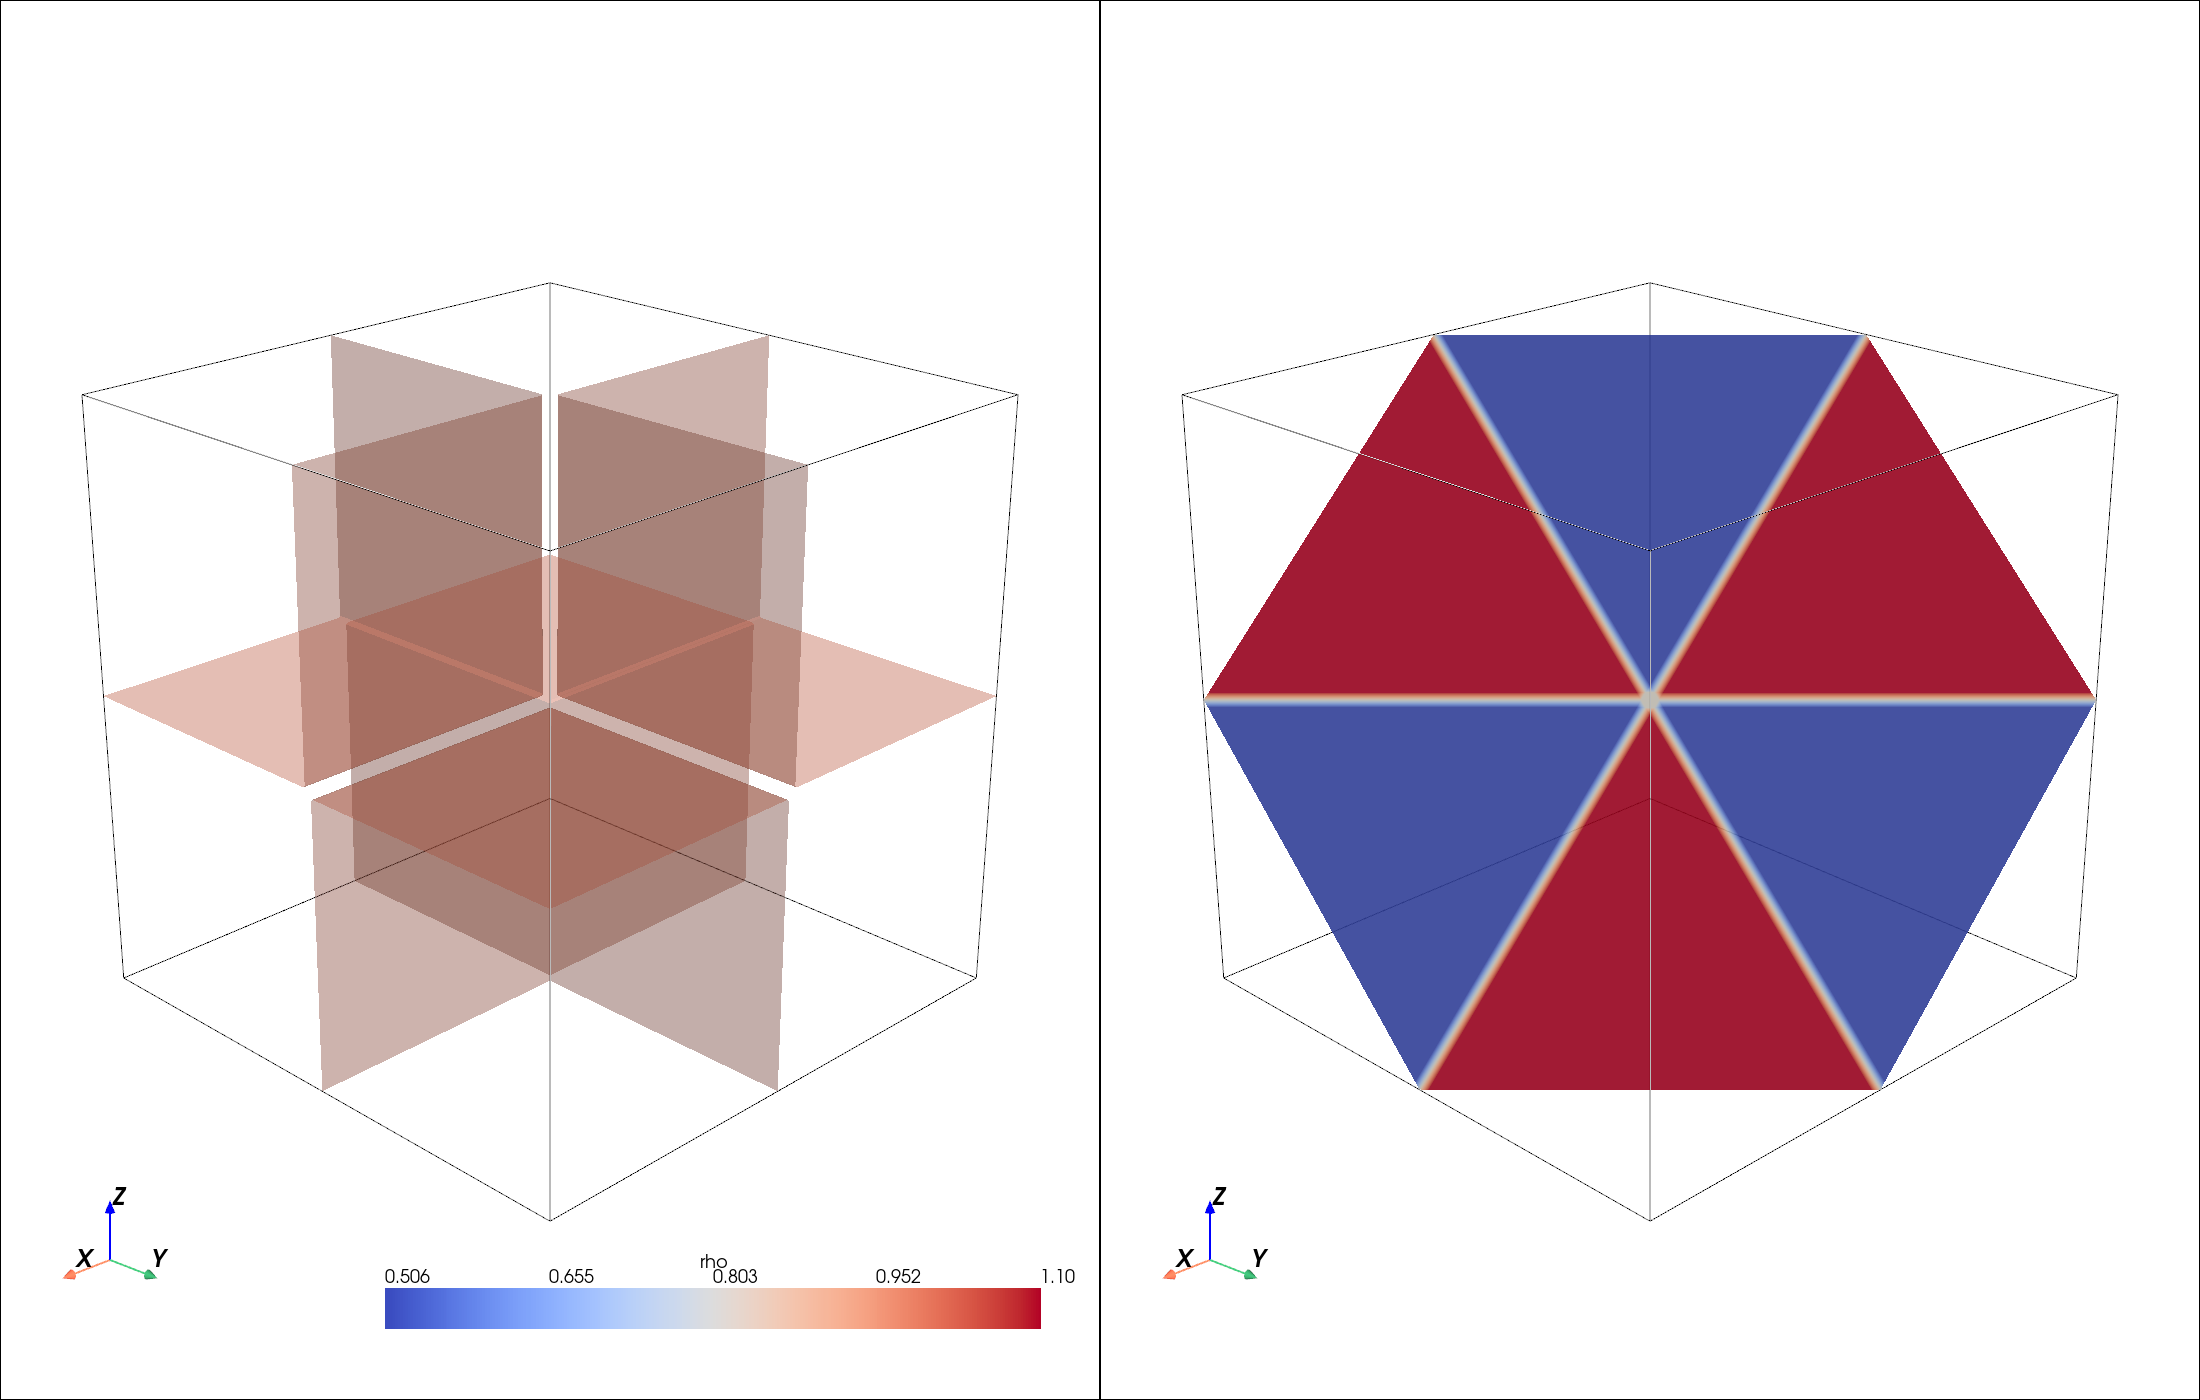

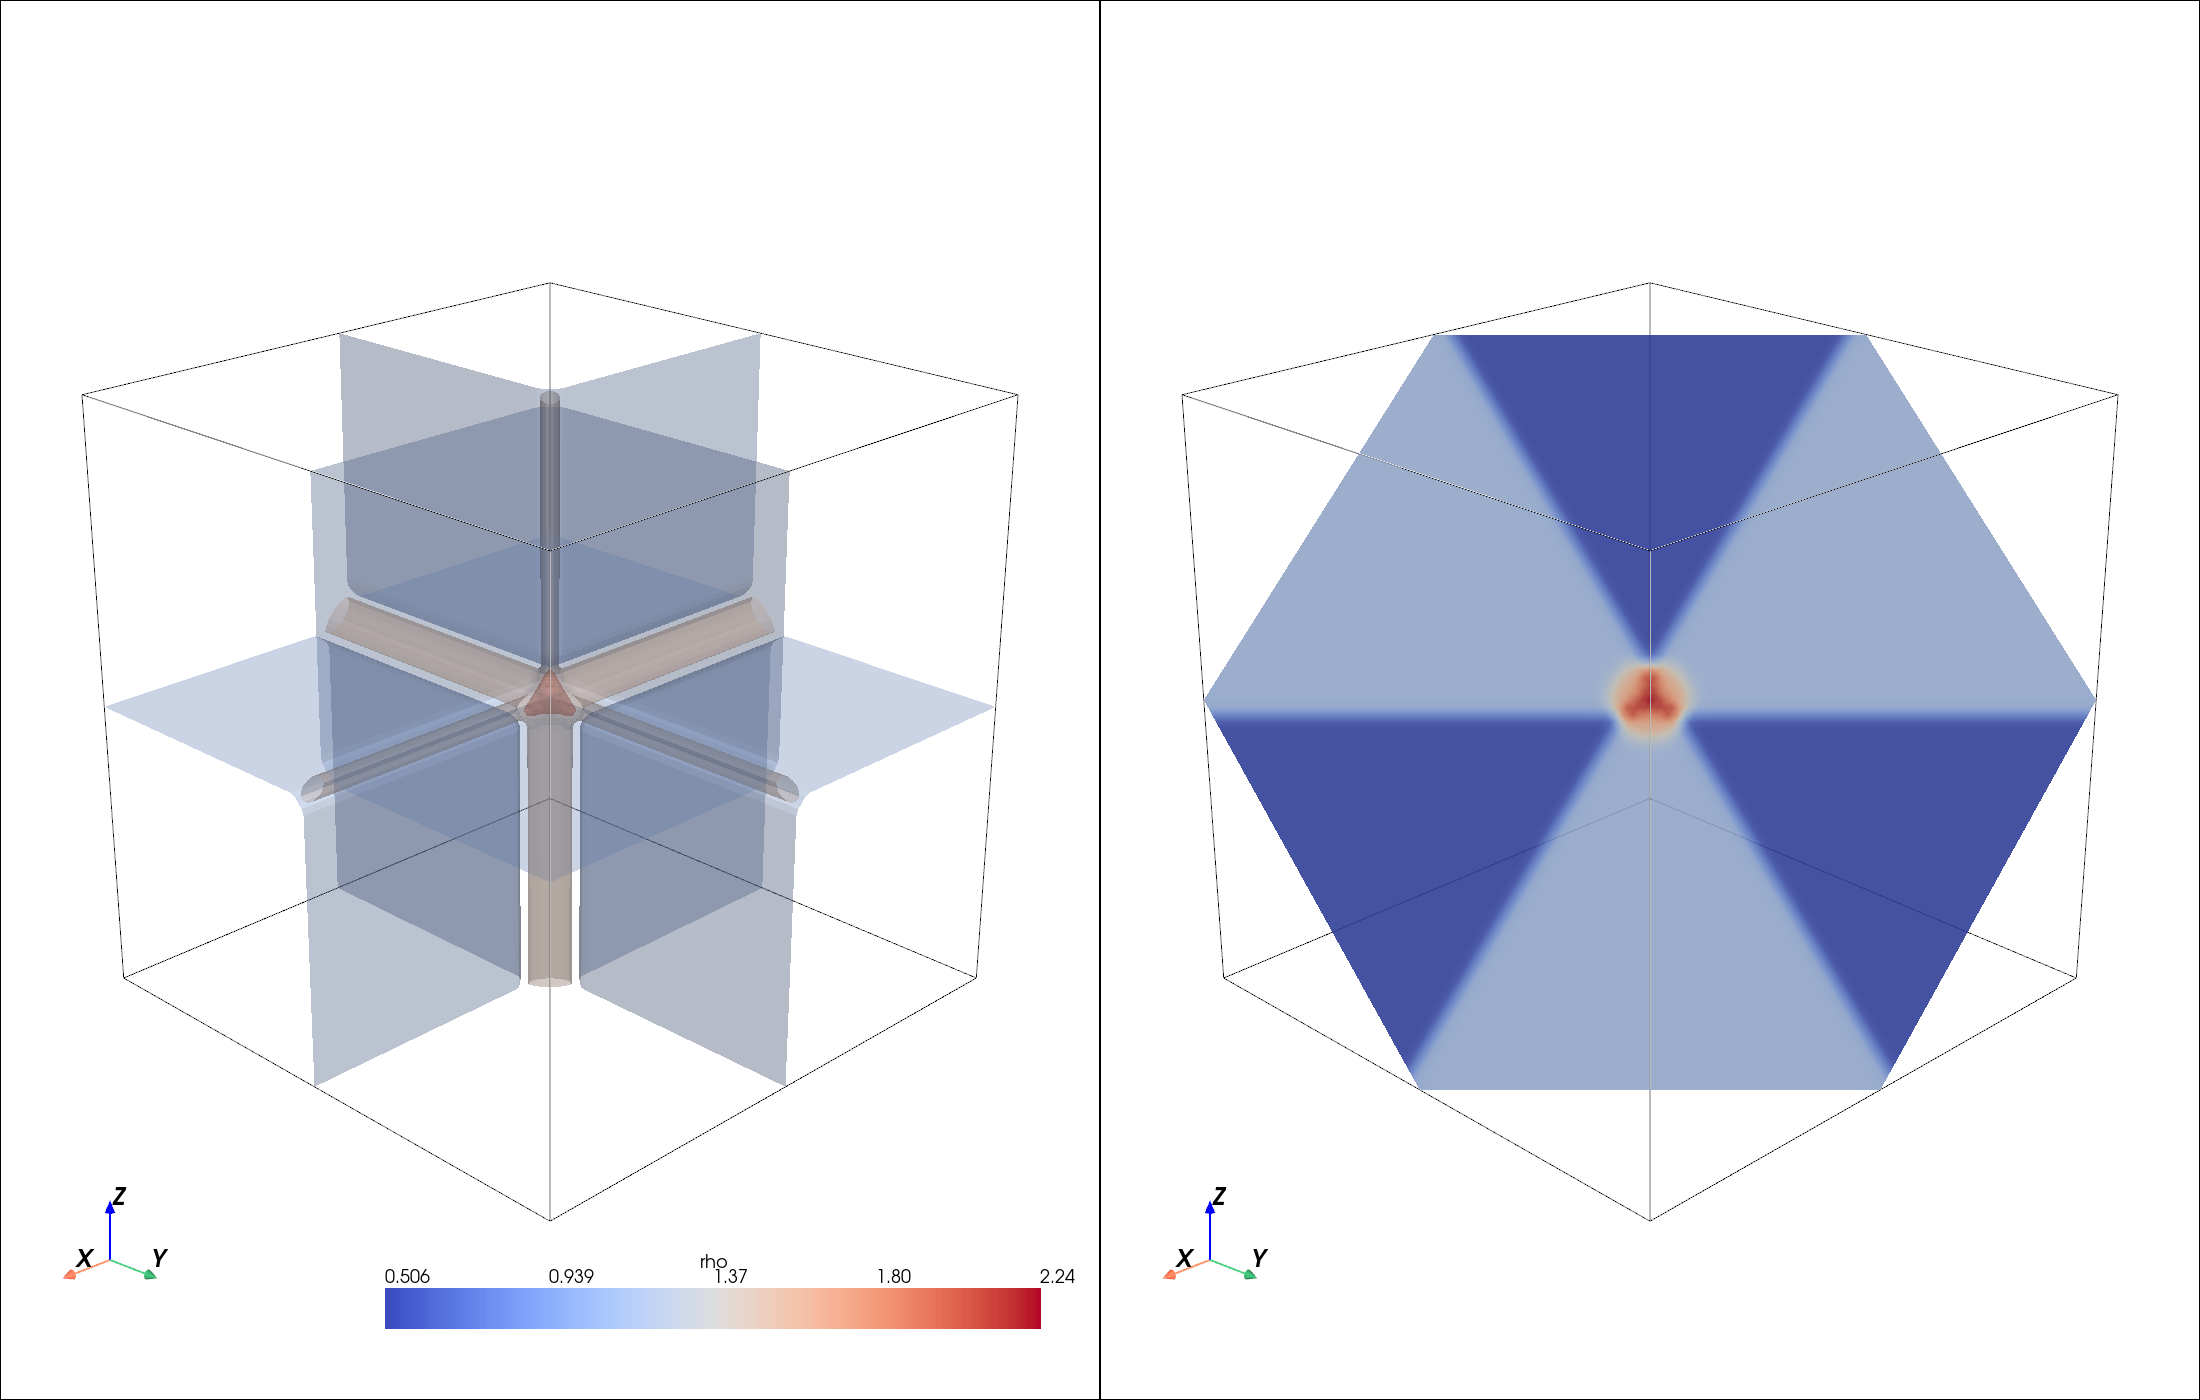

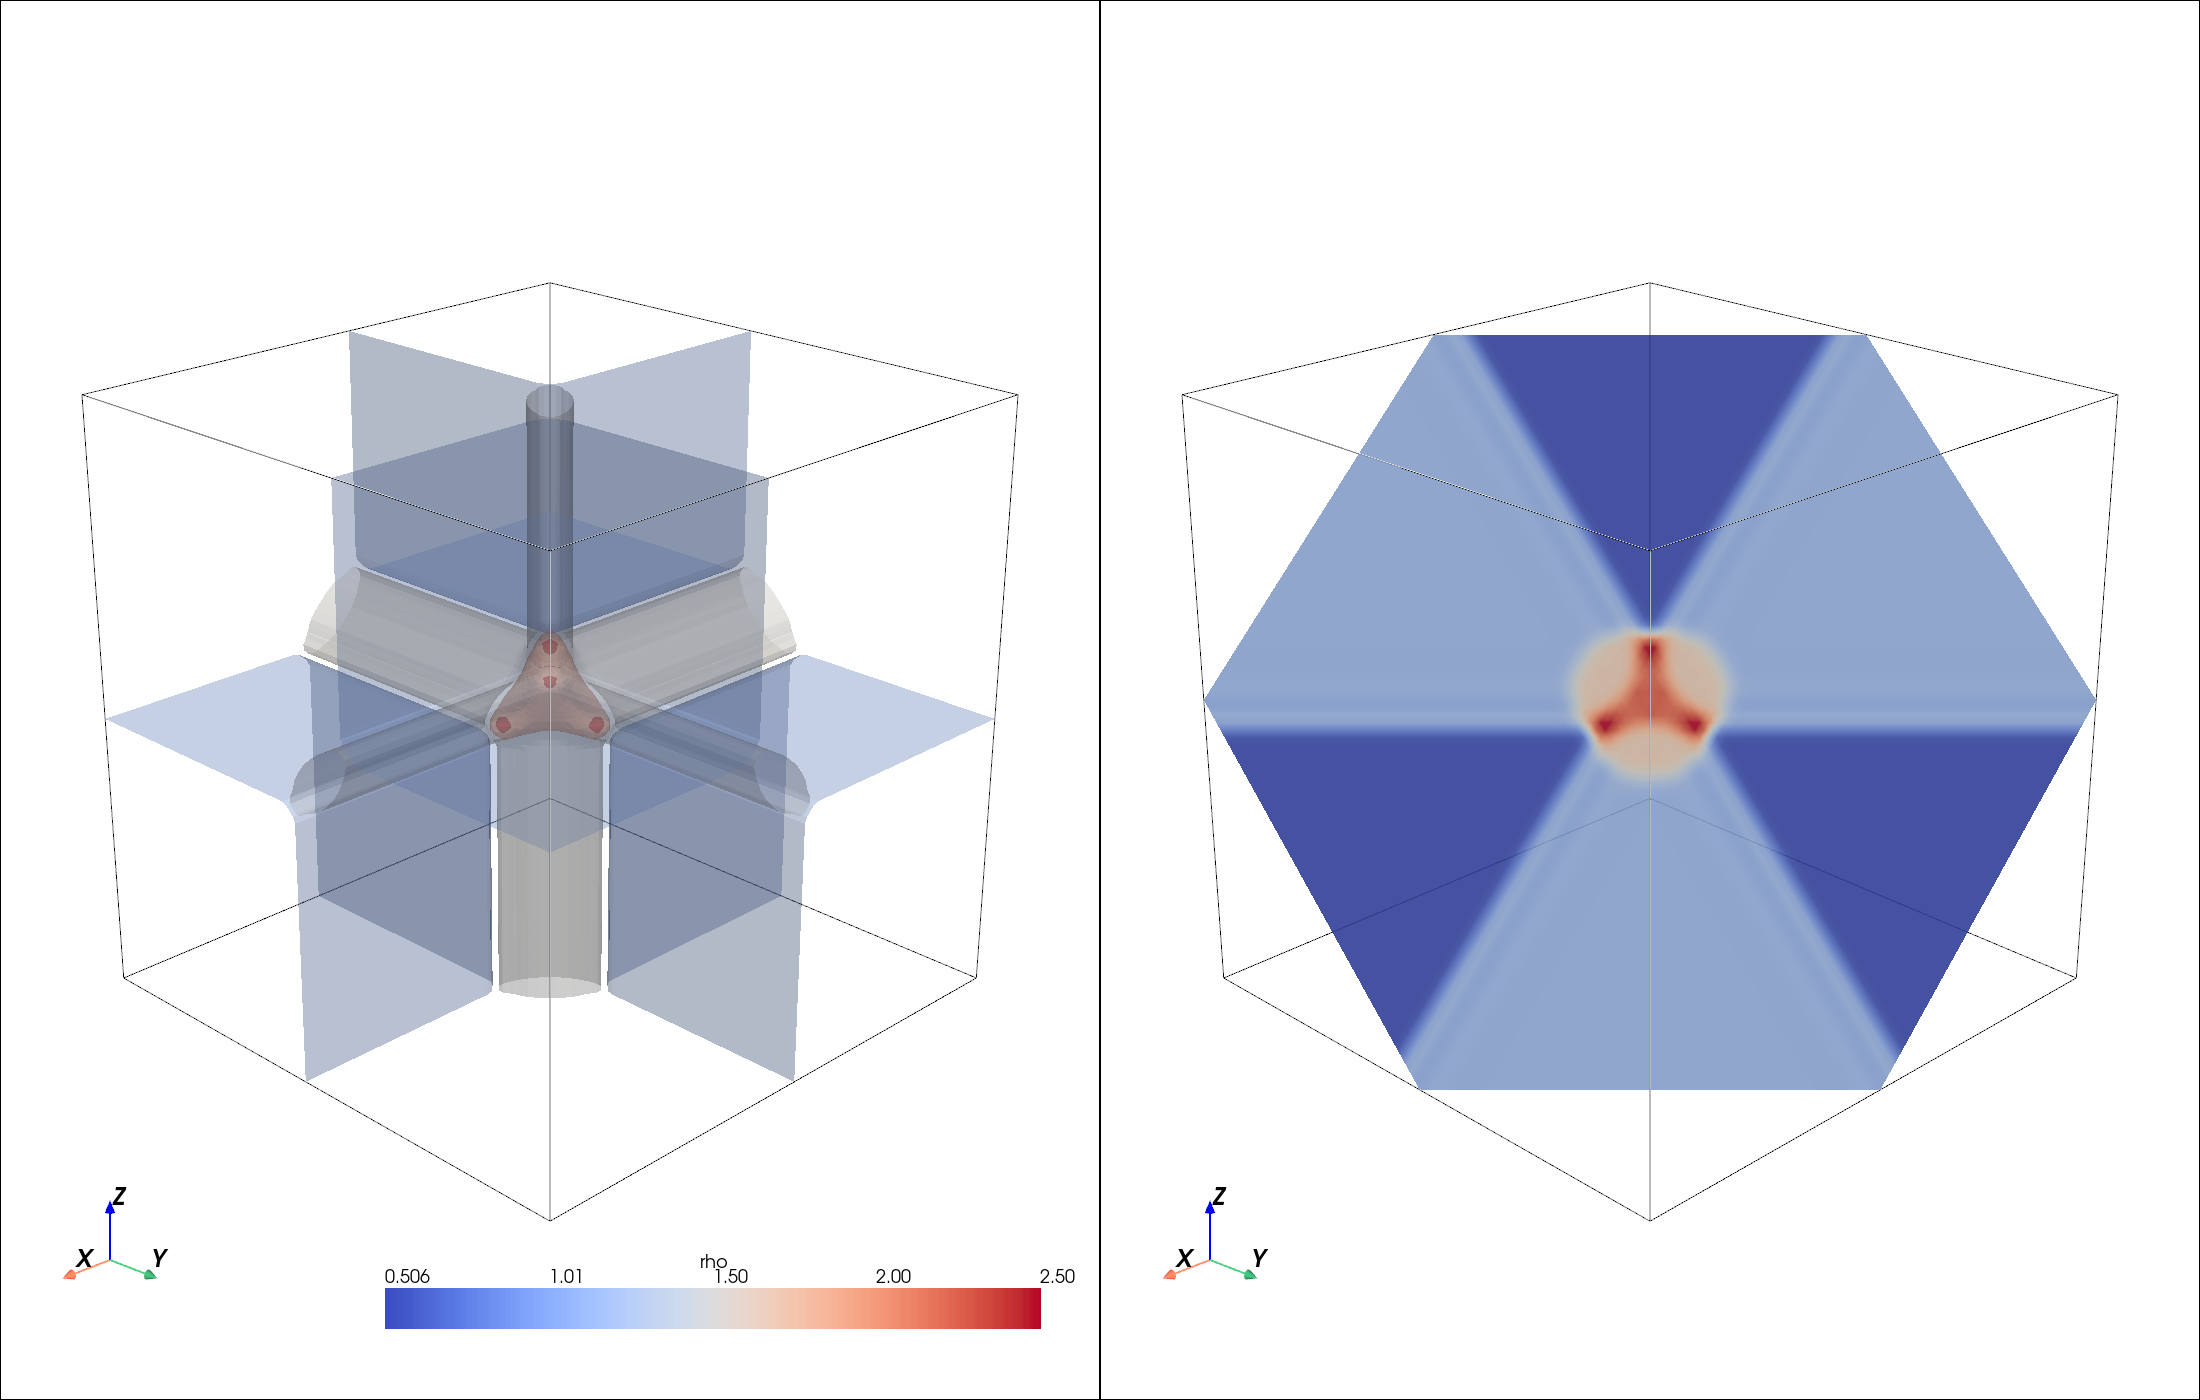

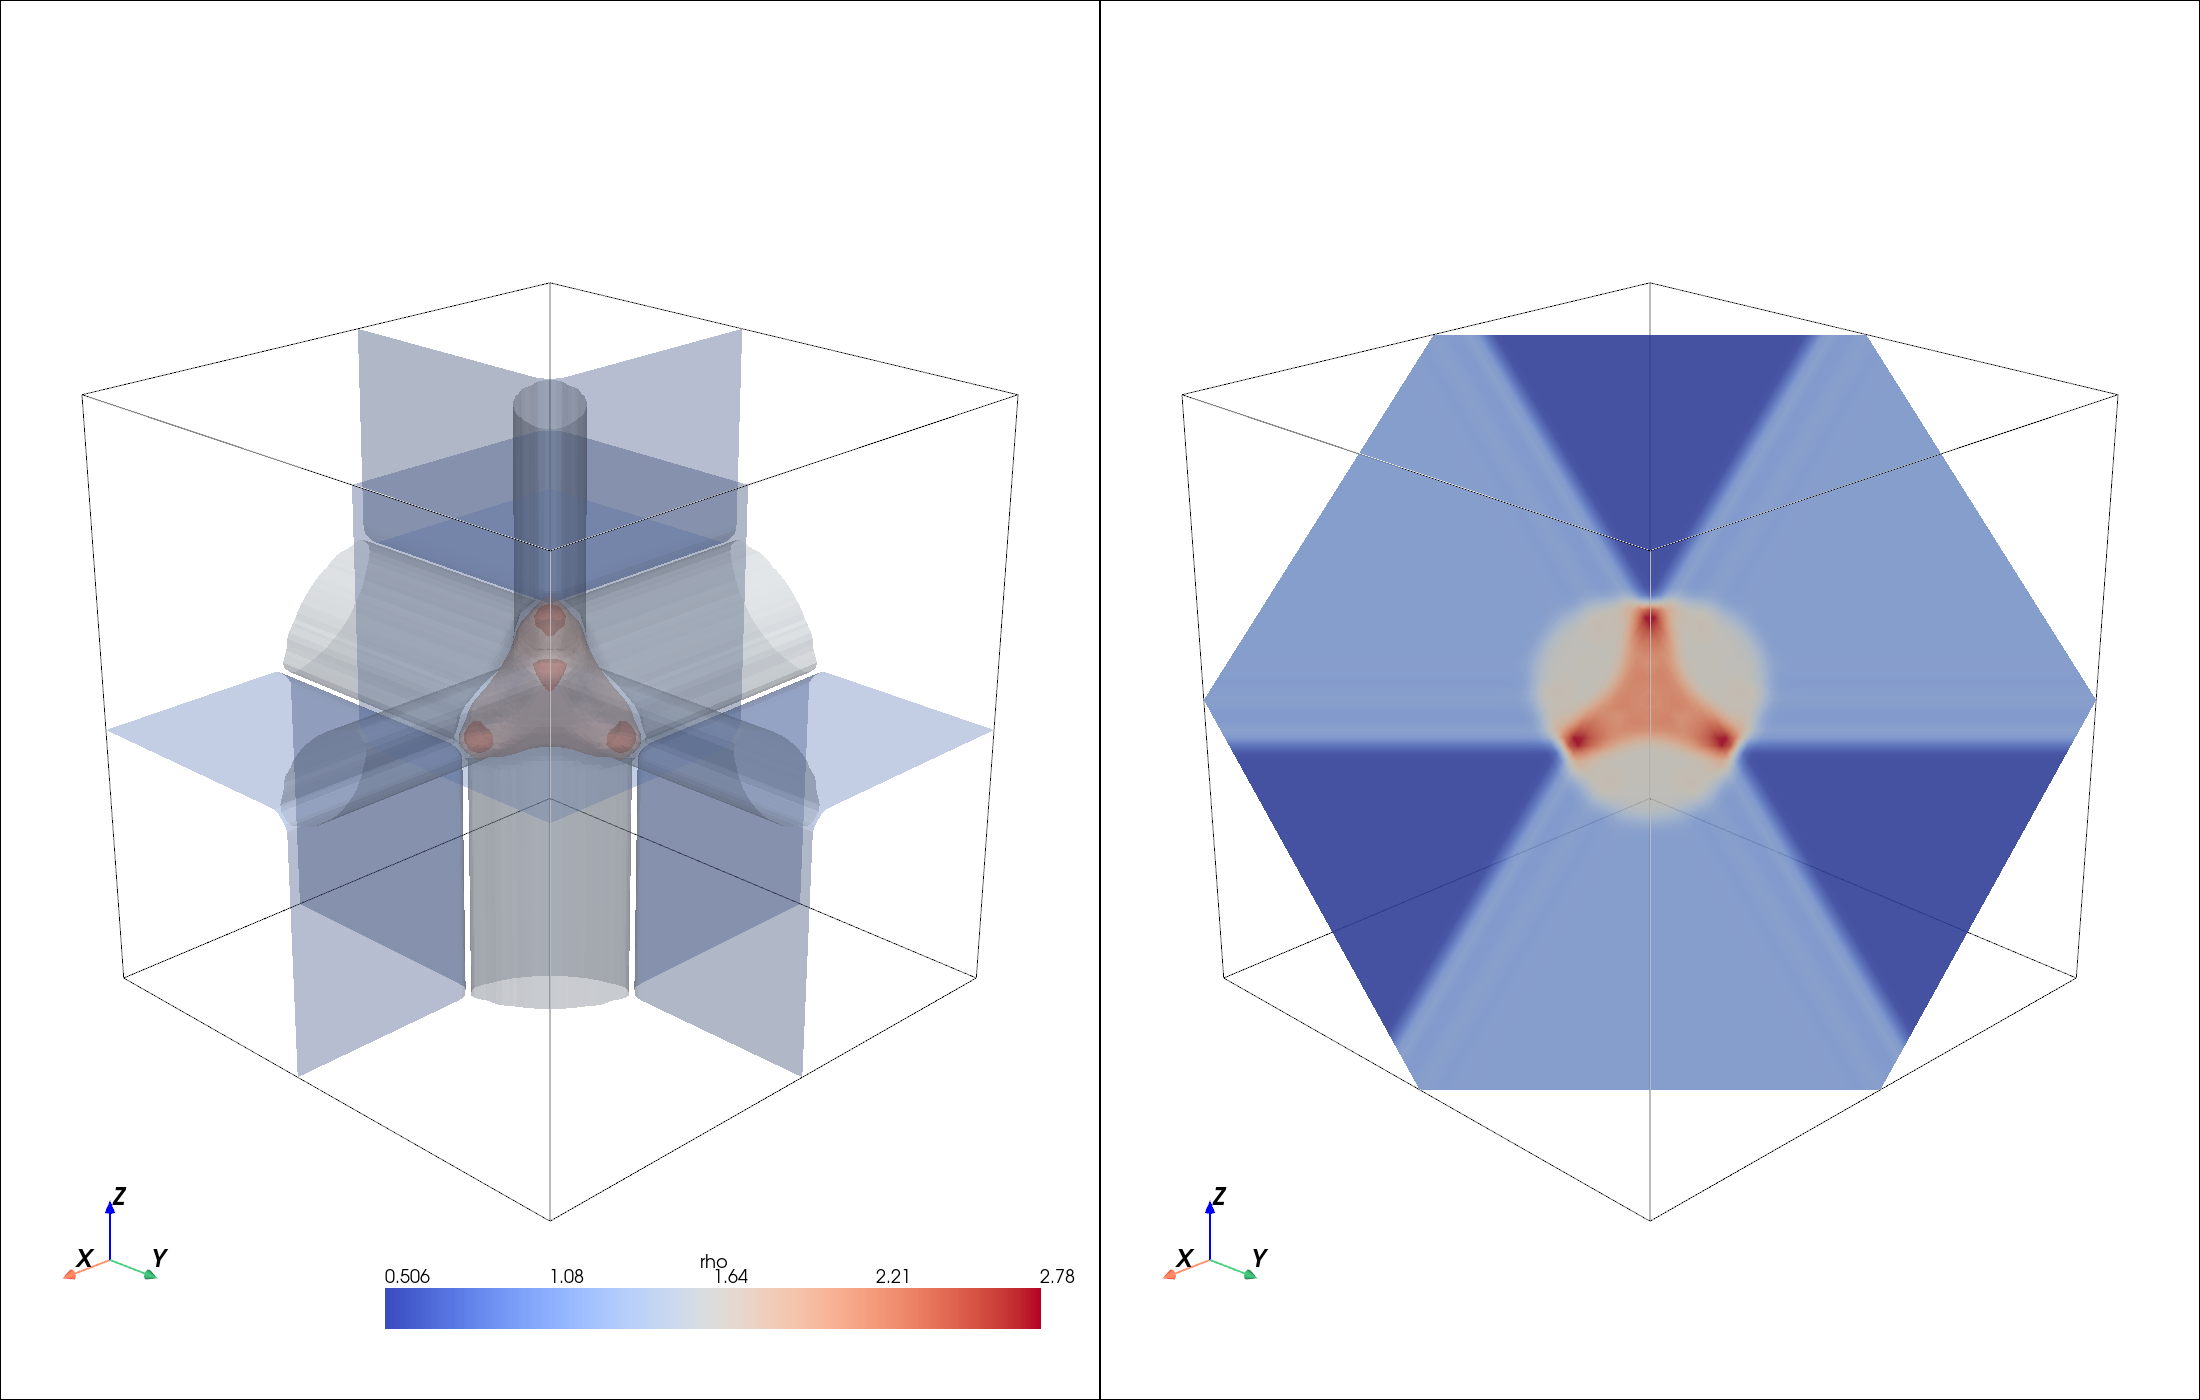

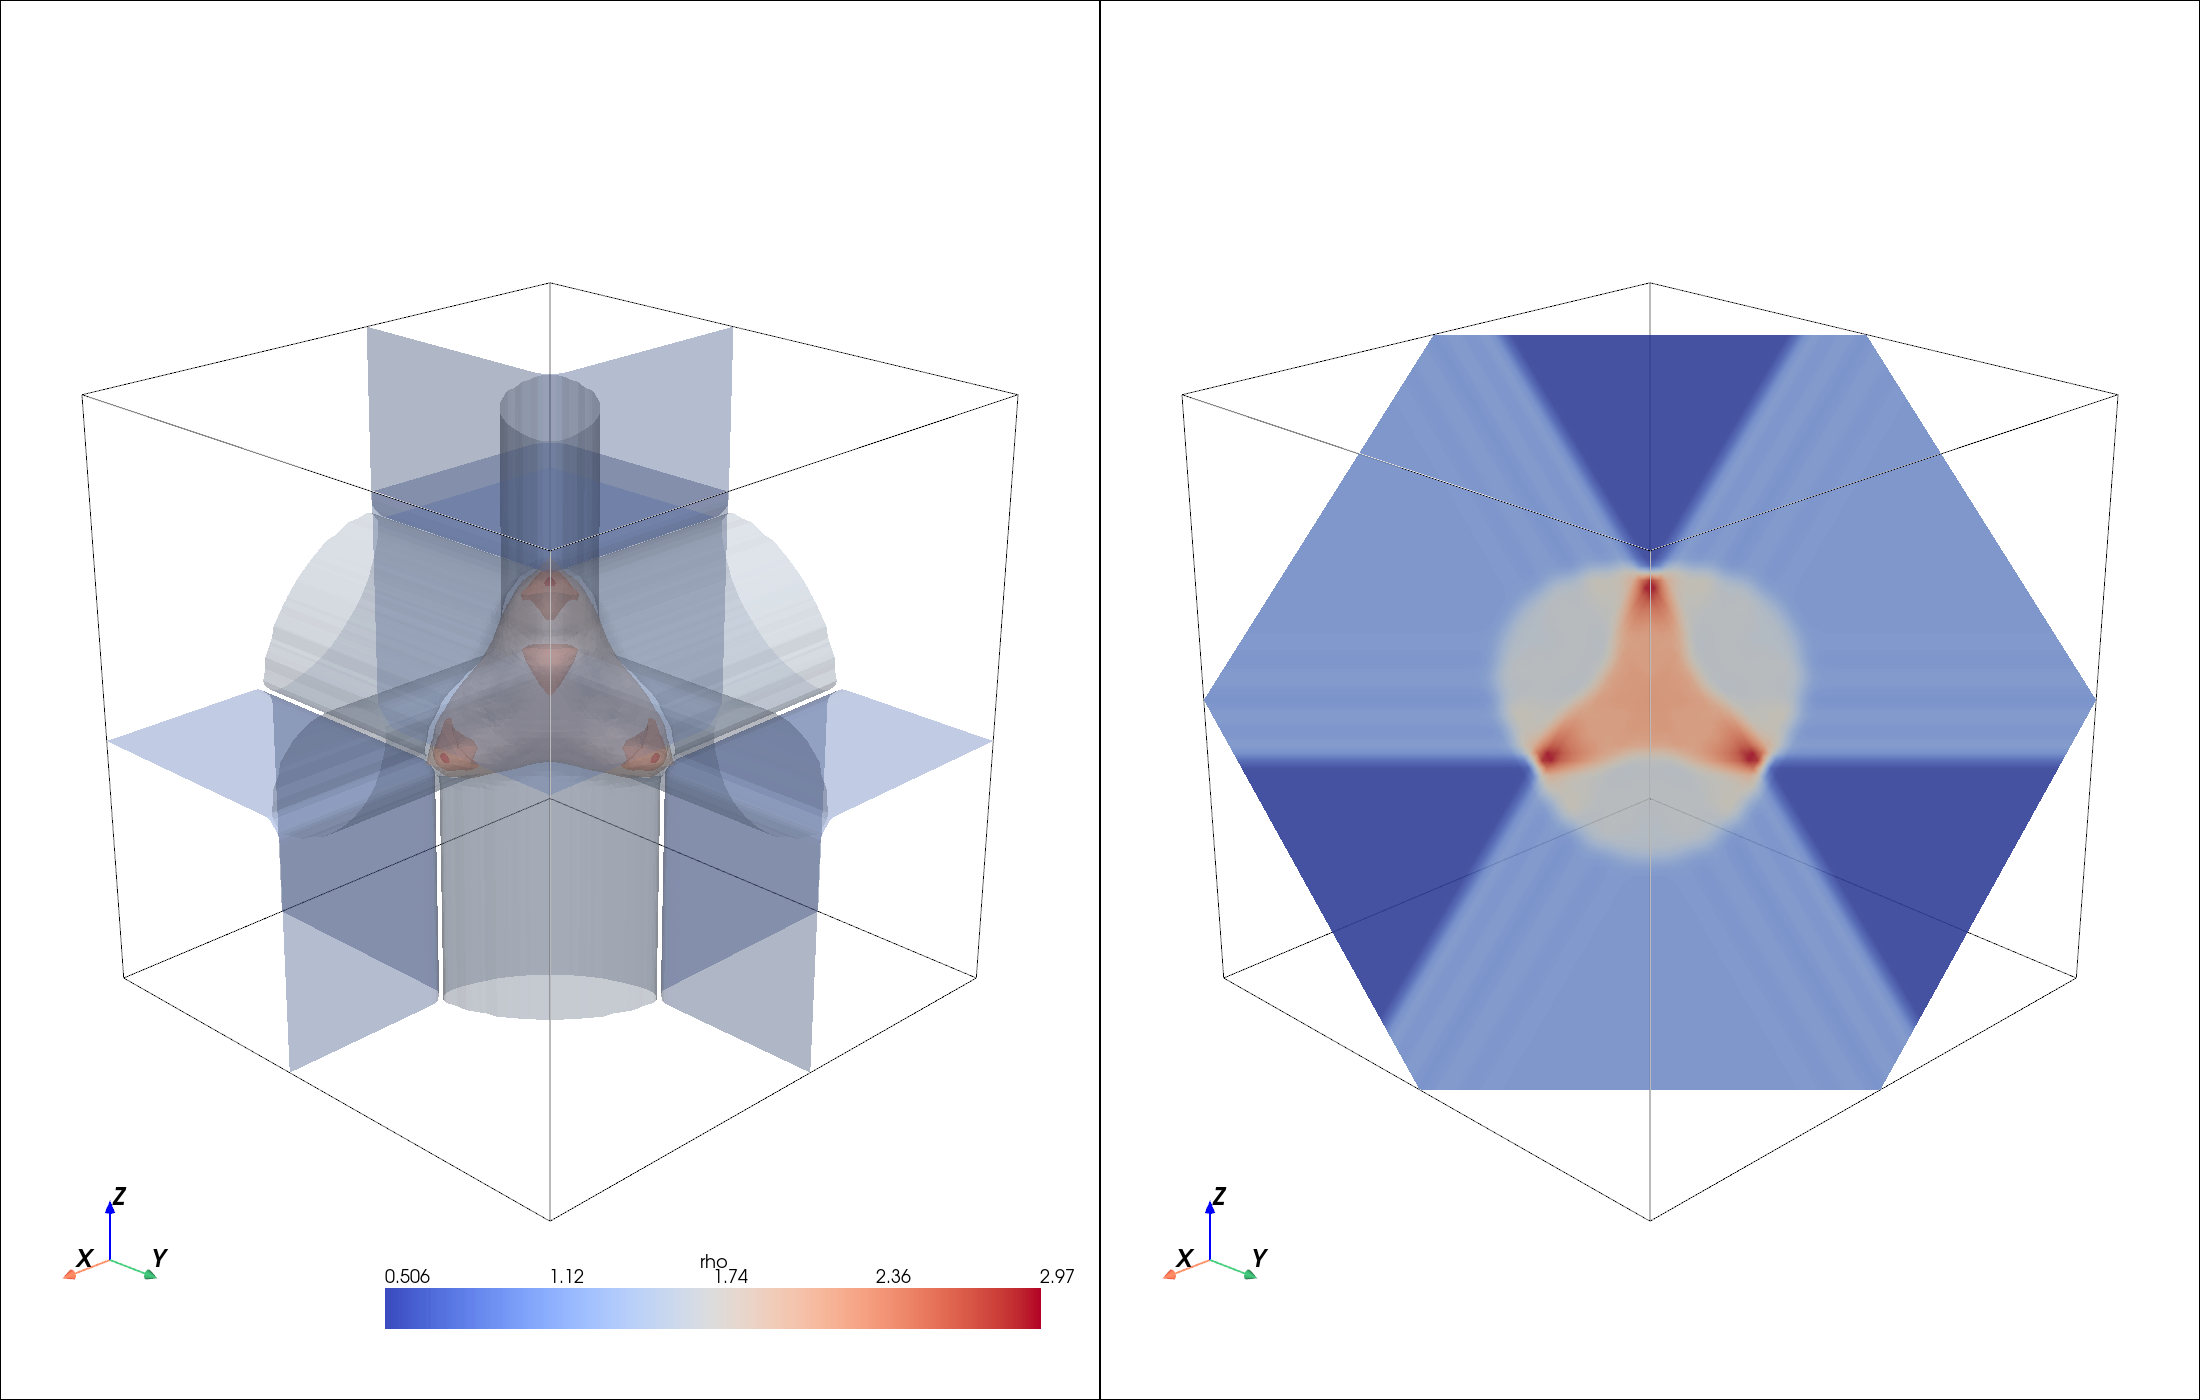

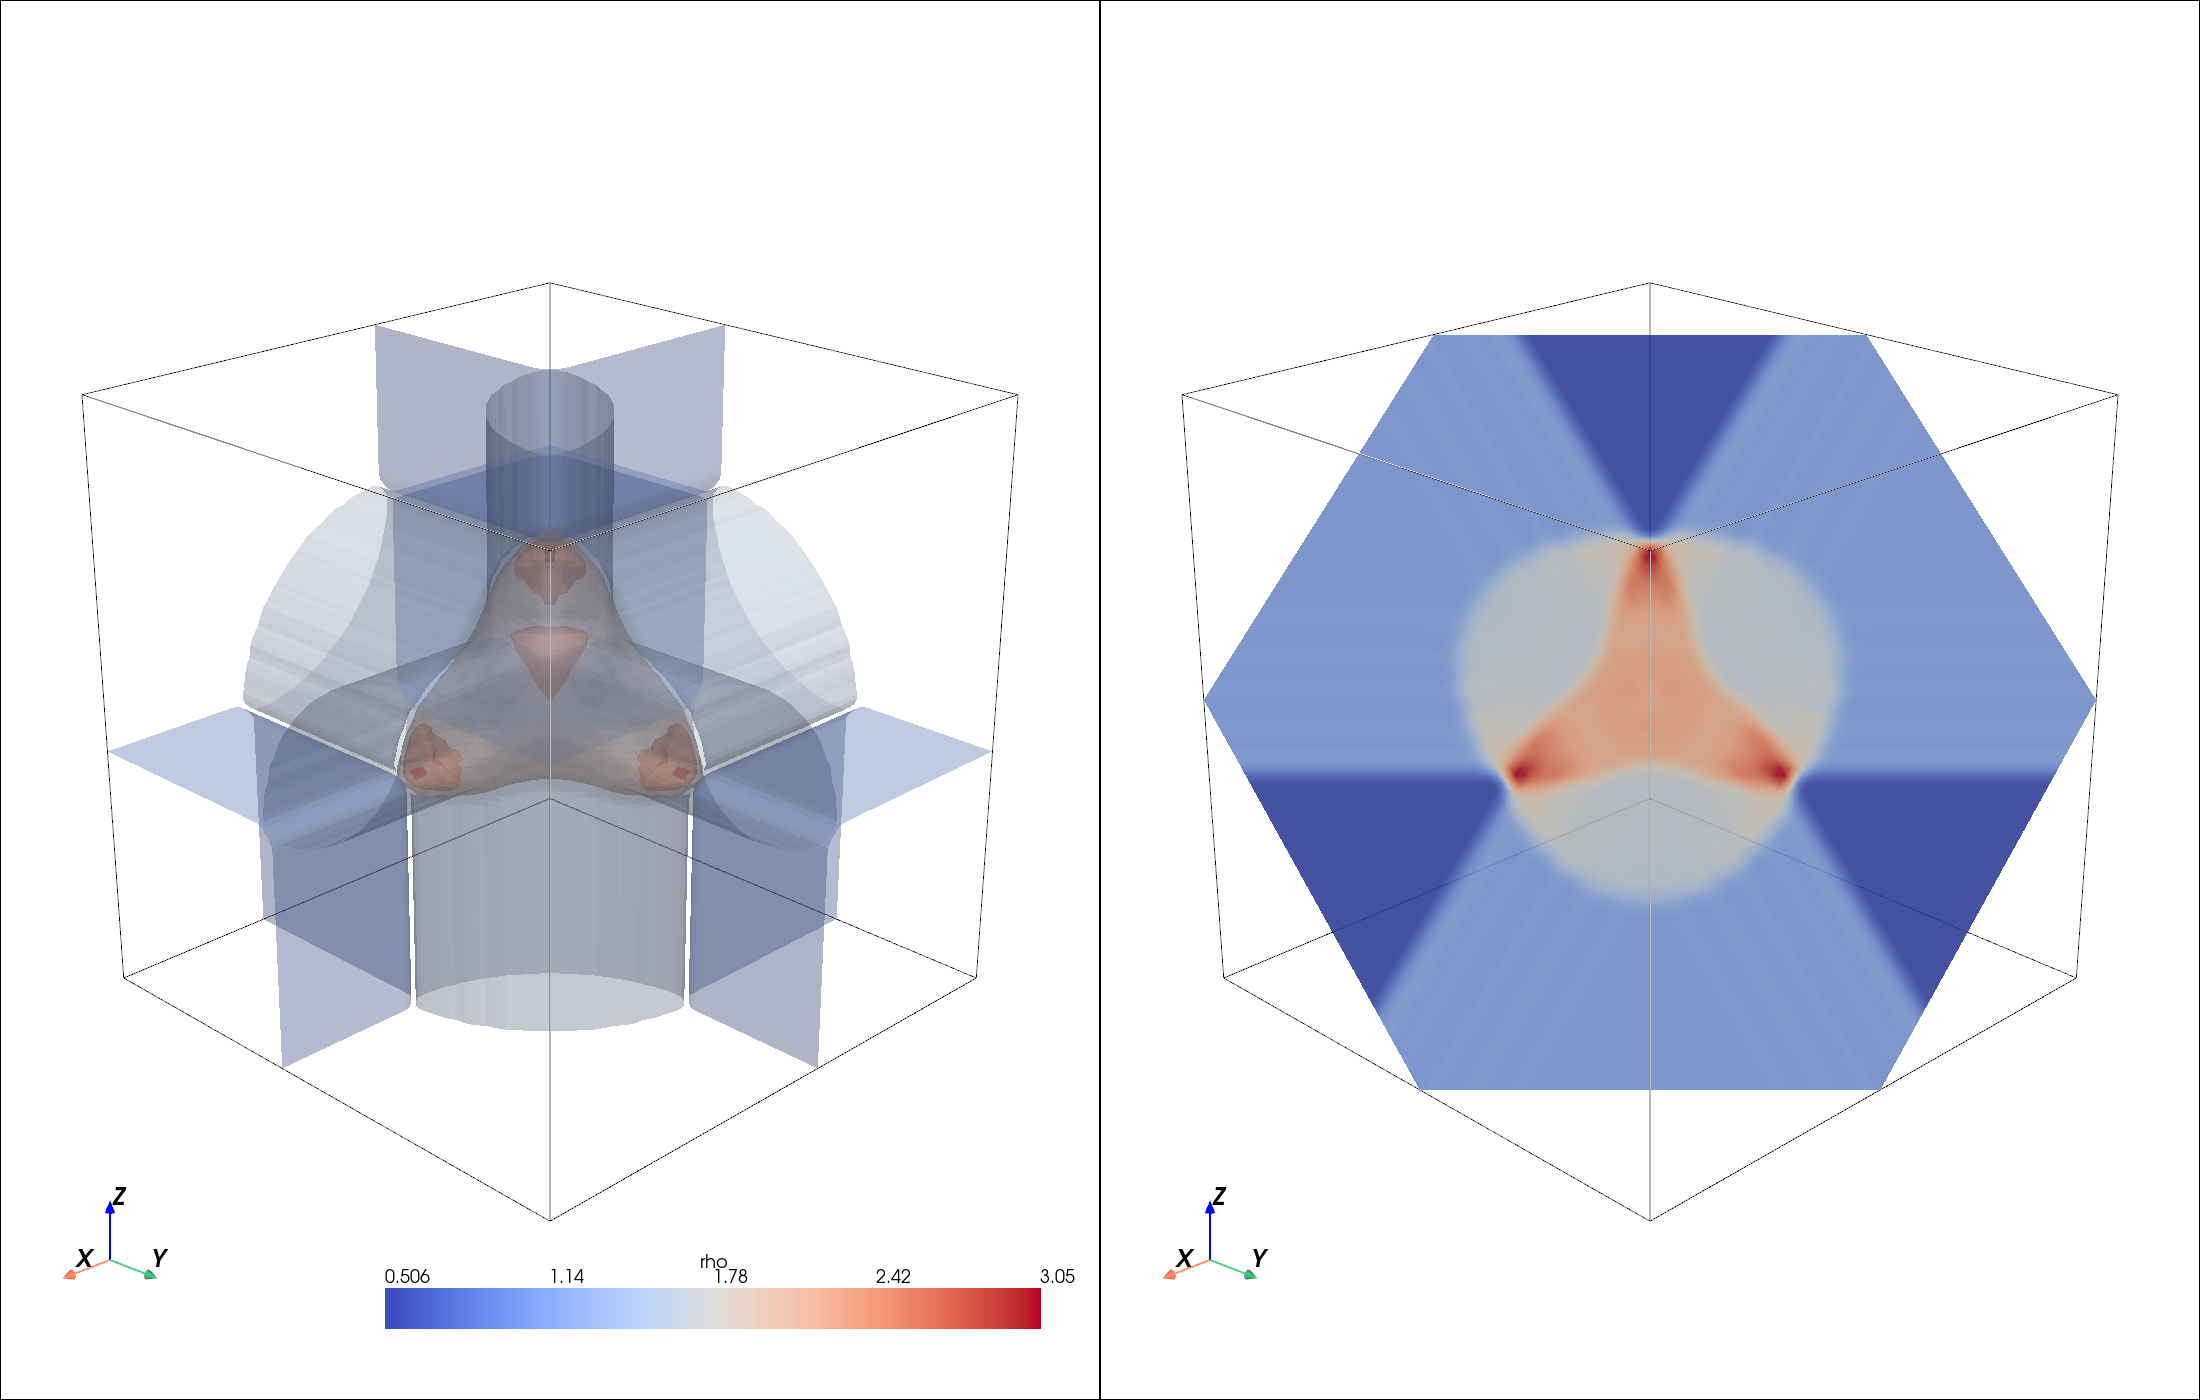

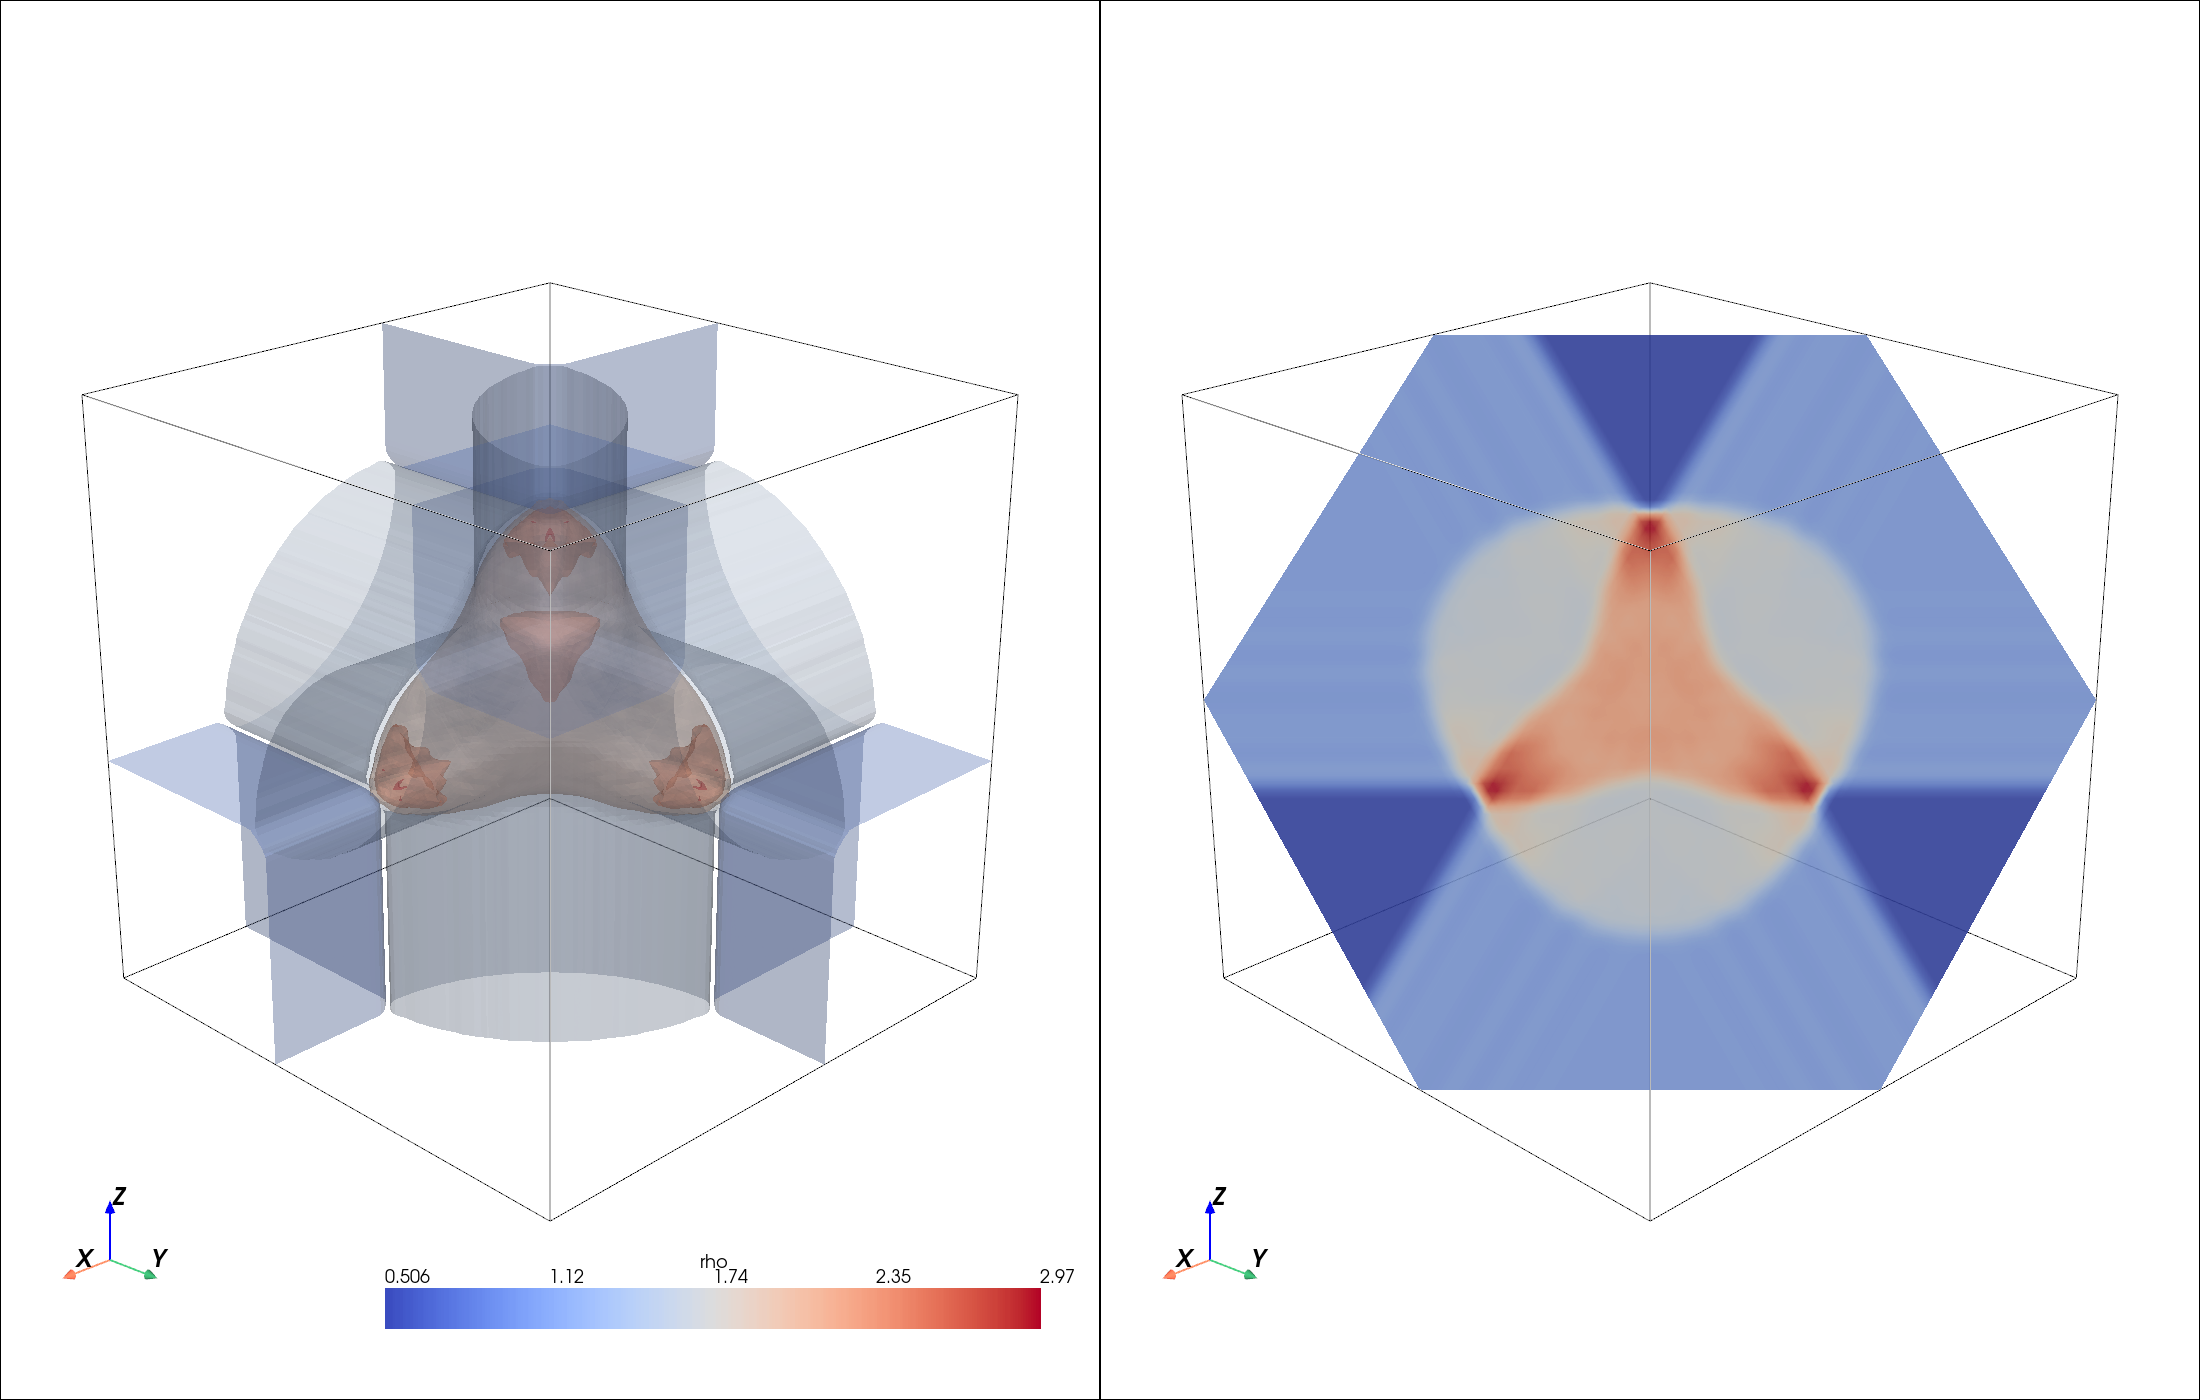

In [10]:
import warnings
warnings.filterwarnings("ignore", module="pyvista")
# Start the virtual framebuffer (Xvfb) to enable off-screen rendering
pv.start_xvfb()

# Find output files
vtk_files = glob(folder_out + "/*.vtk")

# Filter files that contain digits in their filenames
vtk_files_with_digits = [f for f in vtk_files if re.search(r'\d+', os.path.basename(f))]

# Sort the filtered files by the first sequence of digits found in the filenames
files = sorted(vtk_files_with_digits, key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))
lf=len(files)
print(files)

j=0
images = [] 
print("Printing figures in folder"+folder_out)

for fname in files:
    
    vtk_file = fname
    data = pv.read(vtk_file)
    grid = data.compute_cell_sizes().cell_data_to_point_data()
    
    # Create a 1x2 subplot (side by side views)
    plotter = pv.Plotter(shape=(1, 2), window_size=[2200, 1400], off_screen=True)
    
    # Left view - 3D contour plot
    plotter.subplot(0, 0)  # Select the left subplot
    contour_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
    contours = grid.contour(isosurfaces=contour_values, scalars="rho") 
    if contours.n_points > 0:
        plotter.add_mesh(contours, cmap="coolwarm", scalars="rho", opacity=0.4)
    
    # Set the camera for the left view
    plotter.camera_position = [
        (3.2, 3.2, 2.1),  # Camera position (x, y, z)
        (0.5, 0.5, 0.5),  # Focal point (center of the object)
        (0, 0, 1),  # View up vector (defines the up direction)
    ]
    plotter.add_bounding_box(color='black')
    plotter.show_axes()

    # Right view - Sliced plane
    plotter.subplot(0, 1)  # Select the right subplot
    sliced_grid = grid.slice(normal=(1, 1, 1), origin=(0.5, 0.5, 0.5))
    plotter.add_mesh(sliced_grid, cmap="coolwarm", scalars="rho", opacity=0.9)
    
    # Set the camera for the right view (same as left for consistency)
    plotter.camera_position = [
        (3.2, 3.2, 2.1),  # Camera position (x, y, z)
        (0.5, 0.5, 0.5),  # Focal point (center of the object)
        (0, 0, 1),  # View up vector (defines the up direction)
    ]
    plotter.add_bounding_box(color='black')
    plotter.show_axes()

    # Save screenshot and image
    image_path = fname + ".png"
    plotter.show(screenshot=image_path)
    img = plotter.screenshot(return_img=True)
    images.append(img)
    
    j += 1      

gif_path = os.path.join(folder_out, "animation.gif")
imageio.mimsave(gif_path, images, fps=2, loop=0)  # Adjust the duration as needed

And the resulting animation:

![Simulation GIF](../caseRP3D/out/animation.gif)